<a href="https://colab.research.google.com/github/Fatma-Chaouech/NLP/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 

Word2Vec is a technique of word embedding (i.e. representing words as vectors).
Word2Vec has two algorithms : 
*   Skip Gram
*   CBOW

Word2Vec has two training methods : 
*   Hierarchical Softmax
*   Negative Sampling





# Implementation

## Skip Gram Model

### Theory

A Deep Learning Model that takes a word as input and predicts its context words. The model will try to maximize the probability distribution of the words appearing in a certain window around the center words by choosing the best center vector representation. Thus, the objective function is a minimization of negative log likelihood : - the average of the sum at all possible center words of the log of the probability that a word (occuring in a certain window) is a context word given a certain center word.


> 

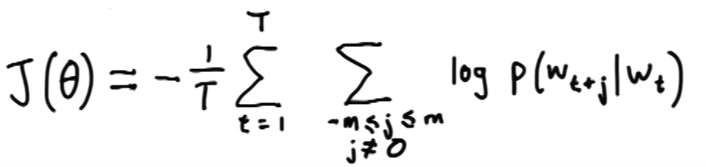




The probability being 


> 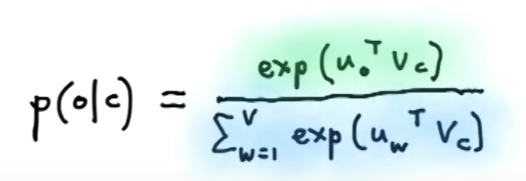


#### Notes



*   The dot product (in the exp) is a measure of similarity. 
*   The probability calculated above has a softmax form. 
*   The exponential is used to make the term positive as we're dealing with probabilities.
*   In order to facilitate the calculations, each word will have 2 vector representations : One when it's the center word and another one when it's a context word.
*   Word2Vec doesn't consider the distance between the center word and the context word when the context word is in the chosen window.

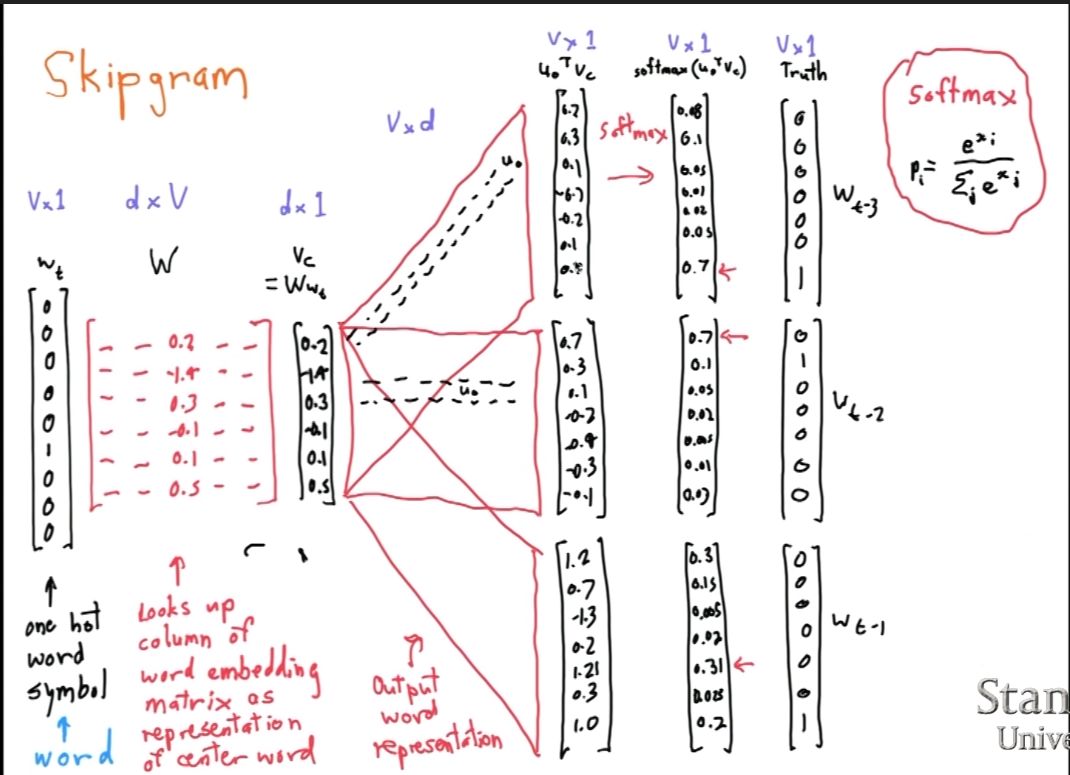



*   w_t*W is the selection of the center word's representation.
*   The next step is the similarity measurement between the center word's representation and the context words' representations (one row for each context word). We multiply the center word's representation with the context words' matrix.
*   After applying the softmax, we get the probability of each word appearing in a context, given a center word.
*   The model computes the loss and performs backpropagation to improve the center vector's representation.
*   The matrix has 2dV size. The 2 is because there's two vectors for each word as we said. 
*   We can't afford to apply one step of gradient descent after iterating over the whole corpus. Instead, we perform batch gradient descent ( one update after a batch of center words ) or stochastic gradient descent ( one update after every center word ).



### Implementation

#### Using Gensim

In [ ]:
import pandas as pd
import re
import spacy

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/datasets/Simpson/simpsons_script_lines.csv')
dataset = dataset[['spoken_words','raw_character_text']]
dataset.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,spoken_words,raw_character_text
0,"No, actually, it was a little of both. Sometim...",Miss Hoover
1,Where's Mr. Bergstrom?,Lisa Simpson
2,I don't know. Although I'd sure like to talk t...,Miss Hoover
3,That life is worth living.,Lisa Simpson
4,The polls will be open from now until the end ...,Edna Krabappel-Flanders


In [ ]:
dataset.shape

(158271, 2)

In [ ]:
dataset.isnull().sum()

spoken_words          26159
raw_character_text    17522
dtype: int64

In [ ]:
dataset = dataset.dropna()
dataset.isnull().sum()

spoken_words          0
raw_character_text    0
dtype: int64

##### Cleaning

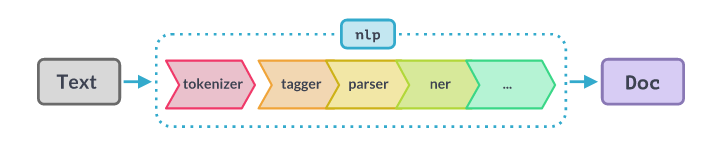

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop] # lemmatizing non-stop words
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)


brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in dataset['spoken_words']) 
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(86210, 1)

##### Bigrams

In [ ]:
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict 


sent = [row.split() for row in df_clean['clean']] # split sentences into words
phrases = Phrases(sent, min_count=30, progress_per=10000) 
bigram = Phraser(phrases) # cut down memory consumption of Phrases()
sentences = bigram[sent] # returns the bigrams possible from sent
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))


sorted(word_freq, key=word_freq.get, reverse=True)[:10]



29719


['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

##### Word2Vec

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True) # makes the model much more memory-efficient

In [ ]:
w2v_model.wv.most_similar(positive = ['homer'])

[('marge', 0.7566145658493042),
 ('good_friend', 0.7535157203674316),
 ('snuggle', 0.7487465143203735),
 ('depressed', 0.74676913022995),
 ('god_sake', 0.7421313524246216),
 ('hammock', 0.7418251037597656),
 ('sweetheart', 0.7389026880264282),
 ('eliza', 0.7332376837730408),
 ('crummy', 0.7310082912445068),
 ('gee', 0.7209245562553406)]

In [ ]:
w2v_model.wv.similarity("homer","dad")

0.6288927

In [ ]:
w2v_model.wv.similarity("mom","marge")

0.6746096

In [ ]:
w2v_model.wv.most_similar(positive=['marge','bart'],negative=['homer'],topn=1)

[('lisa', 0.7614909410476685)]

In [ ]:
w2v_model.wv.most_similar(positive=['marge','donut'],negative=['homer'],topn=1)

[('pork', 0.7252845764160156)]

##### t-SNE visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


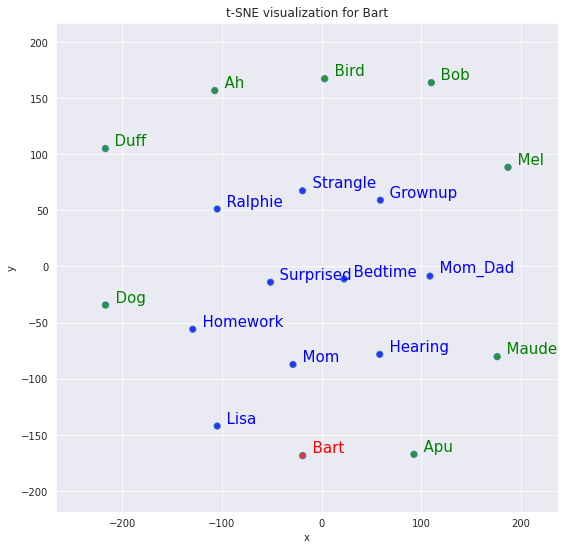

In [ ]:
tsnescatterplot(w2v_model, 'bart', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])